#### Predicting Domain Name Categories with Feature-Engineered Input, Built-in NLP Models, and Supervised Machine Learning Algorithms

In [4]:
#importing os to set environment variable
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install open-jdk
  !java -version       #check java version
install_java()

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [ ]:
# #initilizing spark
# import findspark as fs
# from pyspark.sql import SparkSession
# fs.init()

In [ ]:
# #function to get or create spark singleton instance
# def getSparkSessionInstance():
#     if ("sparkSessionSingletonInstance" not in globals()):
#         globals()["sparkSessionSingletonInstance"] = SparkSession.builder.appName('u219').master("local[*]").config("module","dissertation").getOrCreate()
#     return globals()["sparkSessionSingletonInstance"]

In [ ]:
# spark = getSparkSessionInstance()

In [6]:
#intsalling wordninja and fast-text
!pip install wordninja
!pip install fasttext
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541552 sha256=6cabdd9557153feb813d0f7b33f134d2e4dad518ed2fe7063f7aa09794bf62bf
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393460 sha256=04830c549ee5cc7061cb9f9cfe4fc9db2424d737b24c67809b96f1c0d9061e4f
  Stored in directory: /root/.cache/pip/w

In [7]:
#importing required lib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import wordninja
import fasttext
import fasttext.util
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import  SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tempfile
import os
import seaborn as sns
from sklearn.metrics import roc_curve,auc,precision_recall_curve
from sklearn.preprocessing import label_binarize


CONFIG & Downloads

In [9]:
#download required lib for fasttext and nltk
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('cc.en.300.bin')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Helper Function definitions

In [10]:
#function to extract tokens from the domain name text data.
def get_tokens_from_word_ninja(domain_name):
    matches = wordninja.split(domain_name)
    filtered_sentence = [w for w in matches if not w in stop_words]
    return filtered_sentence

In [11]:
#function to pos tag the  tokens
def get_pos_tagged_tokens(filtered_sentence):
    tags = pos_tag(filtered_sentence, tagset='universal')
    # Extract nouns and verbs
    # initialize lists for each POS category
    nouns = []
    adjectives = []
    verbs = []
    prepositions = []
    adverbs = []
    interjections = []
    pronouns = []


    # loop through the tagged words and add them to the appropriate list
    for word, tag in tags:
        if tag.startswith('N'):
            nouns.append(word)
        elif tag.startswith('V'):
            verbs.append(word)
        elif tag.startswith('J'):
            adjectives.append(word)
        elif tag.startswith('R'):
            adverbs.append(word)
        elif tag == 'PRP':
            pronouns.append(word)
        elif tag == 'IN':
            prepositions.append(word)
        elif tag == 'INTJ':
            interjections.append(word)
    # Create tokens based on nouns and verbs
    tokens = nouns + adjectives + verbs + prepositions + adverbs + interjections + pronouns 
    return list(set(tokens))

In [12]:
#function to obtain the sentence vector for the domain name text
def get_fasttext_word_embeding_feature_vector(model,sentence):
    # features = [model.get_sentence_vector(name) for name in tokens]
    features = model.get_sentence_vector(sentence)
    embedding_vector = np.mean(features, axis=0) 
    return embedding_vector

In [13]:
#function to get the polarity score using SentimentIntensityAnalyzer for the domain name text
def get_sentimental_analysis_features(sentence):
    analyzer = SentimentIntensityAnalyzer() # Create a sentiment analyzer object
    scores = analyzer.polarity_scores(sentence) # Test the sentiment analyzer on a sample sentence
    compunded_result = scores['compound']
    return compunded_result

In [14]:
#function to get the character count of domain name text
def get_char_count(domain):
    return len(domain)

In [15]:
#function to get the word count of domain name text
def get_word_count(domain):
    return len(domain.split())

In [16]:
#function to get the syllable count of domain name text
def get_syllable_count(domain):
    vowels = 'aeiouy'
    count = 0
    for word in domain.split():
        word = re.sub(r'[^\w\s]','',word)
        word_count = 0
        for letter in word:
            if letter in vowels:
                if word_count == 0:
                    count += 1
                word_count += 1
        if word_count > 2:
            count += 1
    return count

In [17]:
#function to get the average word length of domain name text
def get_avg_word_length(words):
    return sum(len(word) for word in words) / len(words)

In [18]:
#function to get the sentence count of domain name text
def get_sentence_count(domain):
    count = 1
    for char in domain:
        if char in ['.', '!', '?']:
            count += 1
    return count

In [19]:
#function to get the flesch kincaid grade level of domain name text
def get_flesch_kincaid_grade_level(domain,sentences_count,syllables_count):
    words = domain.split()
    num_words = len(words)
    return (0.39 * (num_words/sentences_count) + 11.8 * (syllables_count/num_words) - 15.59)



In [20]:
# function to plot the class/category distribution
def analyseClassBalance(target):
    class_counts = target.value_counts()
    # Create a bar plot
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class Label')
    plt.ylabel('Number of Data Points')
    plt.show()

In [21]:
def generate_temp_file(x,y):
        # Write training and validation data to temporary files
    with tempfile.NamedTemporaryFile(mode="w", delete=False) as train_file, \
            tempfile.NamedTemporaryFile(mode="w", delete=False) as valid_file:
        # Write training data to file
        x.apply(lambda row: train_file.write(
            f"__label__{row['label']} {row['domain']}\n"), axis=1)
        train_data_path = train_file.name

        # Write validation data to file
        y.apply(lambda row: valid_file.write(
            f"__label__{row['label']} {row['domain']}\n"), axis=1)
        test_data_path = valid_file.name

        return train_data_path, test_data_path

In [22]:
def generateFastTextModel(_train_data_path):
    # Train FastText model
    model = fasttext.train_supervised(input=_train_data_path,   
        lr= 0.1, # learning rate
        epoch= 100, # number of epochs
        wordNgrams= 3,  # max length of word ngram if it is uni, bi, tri and so on
        bucket= 200000, # number of buckets 
        dim= 100, # size of word vectors
        minn= 2, # min length of char ngram
        maxn= 4, # max length of char ngram
        loss='softmax', #loss function {ns, hs, softmax} [softmax]
    )
    return model


**Read the dataset**
*The dataset is hosted in the Github Public Repository*

In [29]:
url = 'https://raw.githubusercontent.com/ajayane/domain_name_value_prediction/main/coursework_data.csv'
DF = pd.read_csv(url)


#### Read the dataset

In [30]:
DF.head()

,domain,label
0,noriomatsumoto.com,1
1,haplessmales.com,1
2,shivamchatuvedi.com,1
3,dailyfreebieoffer.com,1
4,poniemall.com,1


#### Missing value Analysis

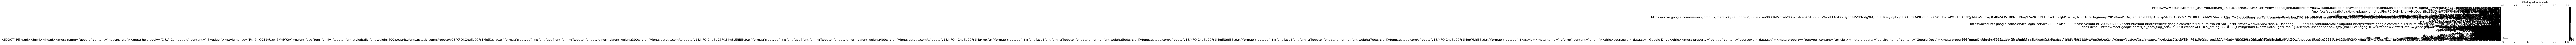

In [25]:
import missingno as msno
fig, ax = plt.subplots(figsize=(6, 3))
msno.bar(DF,ax=ax)
plt.title('Missing value Analysis')
plt.show()

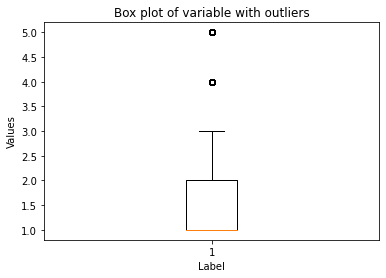

In [ ]:
# Create a box plot of the variable with outliers
plt.boxplot(DF['label'])

# Set the title and labels for the plot
plt.title('Box plot of variable with outliers')
plt.xlabel('Label')
plt.ylabel('Values')

# Show the plot
plt.show()

#### correlation matrix 

<AxesSubplot:>

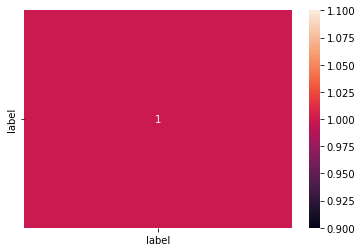

In [ ]:
# Calculate the correlation matrix
corr_matrix = DF.corr()
# print(corr_matrix)

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix,  annot=True)


#### Distribution Plot of the class Label

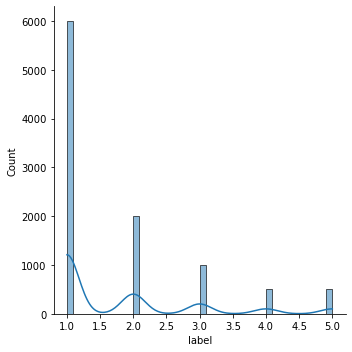

In [ ]:
# Generate a distribution plot of a single variable
sns.displot(DF['label'], kde=True)

#### Feature Extraction

In [ ]:
# Extrat length of the domain 
DF['length'] = DF['domain'].astype(str).str.len()

# Extract special characters from the domians
DF["special_chars"] = DF.apply(lambda p: sum(not q.isalpha() and not q.isdigit() for q in p["domain"]), axis=1)

# Extrct letters from the domains including Uppercase and Lowercase
DF["letters"] = DF.apply(lambda p: sum(q.isalpha() for q in p["domain"]), axis=1)
DF['upper_case'] = DF.apply(lambda p: sum(q.isupper() for q in p['domain']), axis=1)
DF['lower_case'] = DF.apply(lambda p: sum(q.islower() for q in p['domain']), axis=1)

# Separate the letters to vowels and consonants
DF['vowels'] = DF.domain.str.lower().str.count(r'[aeiou]')
DF['consonants'] = DF.domain.str.lower().str.count(r'[a-z]') - DF['vowels']

# Extract numbers from the domains
DF["numbers"] = DF.apply(lambda p: sum(q.isdigit() for q in p["domain"]), axis=1)

#Extract syllable count
DF["syllable_count"] = DF.apply(lambda p: get_syllable_count(p["domain"]), axis=1)


#Extract Sentense count useful when there is sub domains/TLD more
DF["sentence_count"] = DF.apply(lambda p: get_sentence_count(p["domain"]), axis=1)

#Extract the tokens
DF["tokens"] = DF.apply(lambda p:  get_tokens_from_word_ninja(p["domain"]), axis=1)

#Perform word embedings
DF["word_embedding"] = DF.apply(lambda p:  get_fasttext_word_embeding_feature_vector(fasttext_model,' '.join(p["tokens"])), axis=1)

#Perform Sentimental analysis
DF["s_a_c"] = DF.apply(lambda p:  get_sentimental_analysis_features( ' '.join(p["tokens"])), axis=1)


#Extract token count
DF["token_count"] = DF.apply(lambda p: len(p["tokens"]), axis=1)

#get the flesch kincaid grade level for the words in the domain name
DF["f_k_g_l"] = DF.apply(lambda p: get_flesch_kincaid_grade_level(p["domain"],p["sentence_count"],p["syllable_count"]), axis=1)

#Extract avg word length
DF["avg_word_len"] = DF.apply(lambda p: get_avg_word_length(p["tokens"]), axis=1) 



In [ ]:
DF.head()

,domain,label,length,special_chars,letters,upper_case,lower_case,vowels,consonants,numbers,syllable_count,sentence_count,tokens,word_embedding,s_a_c,token_count,f_k_g_l,avg_word_len
0,noriomatsumoto.com,1,18,1,17,0,17,8,9,0,2,2,"[norio, matsumoto, com]",-0.000206,0.0000,3,8.205,5.666667
1,haplessmales.com,1,16,1,15,0,15,5,10,0,2,2,"[hapless, males, com]",0.000396,-0.3400,3,8.205,5.000000
2,shivamchatuvedi.com,1,19,1,18,0,18,7,11,0,2,2,"[shiva, chat, uv, edi, com]",0.002286,0.0000,5,8.205,3.400000
3,dailyfreebieoffer.com,1,21,1,20,0,20,9,11,0,2,2,"[daily, freebie, offer, com]",0.001267,0.4215,4,8.205,5.000000
4,poniemall.com,1,13,1,12,0,12,5,7,0,2,2,"[poni, em, com]",0.001600,0.0000,3,8.205,3.000000


#### class imbalance problem in the dataset

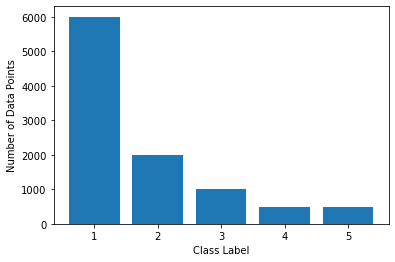

In [ ]:
analyseClassBalance(DF['label'])

#### handling class imbalance problem by Random Over Sampling

In [ ]:
#resampling the dataset
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
x, y = ros.fit_resample(DF, DF['label'])

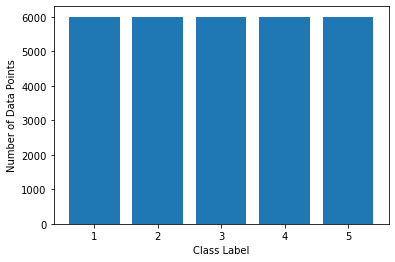

In [ ]:
analyseClassBalance(y)

In [ ]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [ ]:
x.head()

,domain,label,length,special_chars,letters,upper_case,lower_case,vowels,consonants,numbers,syllable_count,sentence_count,tokens,word_embedding,s_a_c,token_count,f_k_g_l,avg_word_len
0,noriomatsumoto.com,1,18,1,17,0,17,8,9,0,2,2,"[norio, matsumoto, com]",-0.000206,0.0000,3,8.205,5.666667
1,haplessmales.com,1,16,1,15,0,15,5,10,0,2,2,"[hapless, males, com]",0.000396,-0.3400,3,8.205,5.000000
2,shivamchatuvedi.com,1,19,1,18,0,18,7,11,0,2,2,"[shiva, chat, uv, edi, com]",0.002286,0.0000,5,8.205,3.400000
3,dailyfreebieoffer.com,1,21,1,20,0,20,9,11,0,2,2,"[daily, freebie, offer, com]",0.001267,0.4215,4,8.205,5.000000
4,poniemall.com,1,13,1,12,0,12,5,7,0,2,2,"[poni, em, com]",0.001600,0.0000,3,8.205,3.000000


In [ ]:
x.shape

(30000, 18)

In [ ]:
y.shape

(30000,)

#### Splitting dataset to train and test

In [ ]:
#split to train and test here.
# 30% - X_test , y_train
# 70% - X_train , y_train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### Generating temporary file to feed to fastText Supervised NLP Model

In [ ]:
train_data_path, test_data_path =generate_temp_file(X_train,X_test)

print(train_data_path)
print(test_data_path)

C:\Users\admin\AppData\Local\Temp\tmpaizpwycw
C:\Users\admin\AppData\Local\Temp\tmpcddb7ih7


#### Generate the fastText supervised model for the train and test data

In [ ]:
fastTextTrainedModelTrain = generateFastTextModel(train_data_path)
fastTextTrainedModelTest = generateFastTextModel(test_data_path)

#### Remove the unwanted columns from the train and test dataset

In [ ]:
X_train = X_train.drop('domain', axis=1)
X_train = X_train.drop('tokens', axis=1)
X_train = X_train.drop('label', axis=1)

X_train.head()

,length,special_chars,letters,upper_case,lower_case,vowels,consonants,numbers,syllable_count,sentence_count,word_embedding,s_a_c,token_count,f_k_g_l,avg_word_len
28465,9,1,8,0,8,4,4,0,2,2,0.004982,0.0000,2,8.205,3.500000
27622,11,1,10,0,10,4,6,0,2,2,-0.002406,0.0000,3,8.205,3.333333
28376,9,1,8,0,8,3,5,0,2,2,0.001298,0.0000,2,8.205,3.000000
10917,23,1,22,0,22,9,13,0,2,2,-0.000027,0.6369,3,8.205,6.000000
27234,11,1,10,0,10,5,5,0,2,2,0.003585,0.0000,2,8.205,3.000000


In [ ]:
X_test = X_test.drop('domain', axis=1)
X_test = X_test.drop('tokens', axis=1)
X_test = X_test.drop('label', axis=1)
# X_resampled = X_resampled.drop('tokens', axis=1)
X_test.head()

,length,special_chars,letters,upper_case,lower_case,vowels,consonants,numbers,syllable_count,sentence_count,word_embedding,s_a_c,token_count,f_k_g_l,avg_word_len
2308,14,1,13,0,13,5,8,0,2,2,0.001419,0.0,4,8.205,3.250000
22404,11,1,10,0,10,3,7,0,2,2,0.000316,0.0,3,8.205,3.333333
23397,12,1,11,0,11,4,7,0,2,2,0.001932,0.0,3,8.205,3.666667
25058,10,1,9,0,9,3,6,0,2,2,-0.000349,0.0,2,8.205,3.500000
2664,18,1,17,0,17,7,10,0,2,2,0.001049,0.0,2,8.205,3.500000


####  combine the features from fastText trained model to train and test dataset

In [ ]:
X_train_fasttext = np.zeros((len(X_train), fastTextTrainedModelTrain.get_dimension()))
X_test_fasttext = np.zeros((len(X_test), fastTextTrainedModelTest.get_dimension()))

In [ ]:
for i, text in enumerate(X_train):
    X_train_fasttext[i] = fastTextTrainedModelTrain.get_sentence_vector(text)

for i, text in enumerate(X_test):
    X_test_fasttext[i] = fastTextTrainedModelTest.get_sentence_vector(text)

In [ ]:
X_Train_combined = np.hstack((X_train, X_train_fasttext))
X_Test_combined = np.hstack((X_test, X_test_fasttext))

In [ ]:
x_train_final = X_Train_combined
x_test_final = X_Test_combined

#### Analyse the size of train and test data

In [ ]:
print("LENGTH OF x_train is ", len(x_train_final))
print("LENGTH OF x_test is ", len(x_test_final))
print("LENGTH OF y_train is ", len(y_train))
print("LENGTH OF y_test is ", len(y_test))

LENGTH OF x_train is  21000
LENGTH OF x_test is  9000
LENGTH OF y_train is  21000
LENGTH OF y_test is  9000


#### Scale the data using a StandardScaler

In [ ]:
# standardscaler = StandardScaler()
# x_train_final = standardscaler.fit_transform(x_train_final)
# x_test_final = standardscaler.transform(x_test_final)

# print('xTrain after scalar is\n', x_train_final)
# print('-----------------------------------------------------------------')
# print('xTest after scalar is\n', x_test_final)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

def genrateClassificationReport(_x_train,_x_test, _y_train, _y_test):
    # create an empty dataframe to store the scores
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    used_classifiers = { 'KNN':{'clf':KNeighborsClassifier(),'result':{}},'DT':{'clf':DecisionTreeClassifier(),'result':{}},'RF':{'clf':RandomForestClassifier(),'result':{}},}
    final_result = {'classifier':used_classifiers, 'results_df':results_df}
   
    # loop through each classifier and calculate the scores
    for key in used_classifiers.keys():
        clf = used_classifiers[key]['clf']
        clf.fit(_x_train, _y_train)
        y_pred = clf.predict(_x_test)
        accuracy = accuracy_score(_y_test, y_pred)
        precision = precision_score(_y_test, y_pred,average='weighted')
        recall = recall_score(_y_test, y_pred,average='weighted')
        f1 = f1_score(_y_test, y_pred,average='weighted')
        cm = confusion_matrix(_y_test, y_pred)

        
        result = {'Classifier': key, 'Accuracy': accuracy, 'Precision': precision, 
                                        'Recall': recall, 'F1-score': f1, 'cm':cm}
        used_classifiers[key]['result'] = result
        used_classifiers[key]['y_pred'] = y_pred
        final_result['results_df'] = final_result['results_df'].append(result,ignore_index=True)

    # print the results table
    return final_result

In [ ]:
results_obj = genrateClassificationReport(x_train_final,x_test_final, y_train, y_test)

In [ ]:
results_obj['results_df']

,Classifier,Accuracy,Precision,Recall,F1-score,cm
0,KNN,0.795333,0.788436,0.795333,0.784216,"[[961, 331, 245, 148, 97], [216, 1092, 250, 13..."
1,DT,0.912333,0.914114,0.912333,0.907699,"[[1178, 315, 152, 76, 61], [80, 1655, 48, 17, ..."
2,RF,0.923000,0.923560,0.923000,0.919993,"[[1286, 250, 129, 71, 46], [82, 1646, 40, 28, ..."


In [ ]:
x_train_final.shape
results_obj['classifier']['RF']['y_pred'].shape

(9000,)

In [ ]:
def generateRUCAUCCurve(cm,_y_test,_y_pred):
    #Compute the correct recall and true positive rate for each class
    cr_list = []
    tpr_list = []
    n_classes = 5
    for i in range(n_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        tpr = tp / (tp + fn)
        cr = tp / np.sum(_y_test == i)
        cr_list.append(cr)
        tpr_list.append(tpr)

    # Plot the RUC curve for each class
    plt.figure()
    plt.plot(tpr_list, cr_list, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('True Positive Rate')
    plt.ylabel('Correct Recall')
    plt.title('RUC Curve')
    plt.show()

    # Compute the AUC-RUC for each class and average them
    auc_list = []
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(_y_test == i, _y_pred[:, i])
        auc_val = auc(tpr, fpr)
        auc_list.append(auc_val)
    avg_auc_ruc = np.mean(auc_list)
    print('Average AUC-RUC:', avg_auc_ruc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

def plot_scores(cm,y_true, y_pred, name):

    # Compute F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Compute accuracy score
    acc = accuracy_score(y_true, y_pred)
    
    # Set up figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 6),gridspec_kw={'width_ratios': [3, 1, 1]})
    
    # Plot confusion matrix
    axs[0].set_title('Confusion matrix of ' + name)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axs[0])
    axs[0].set_xlabel('Predicted labels')
    axs[0].set_ylabel('True labels')
    axs[0].set_xticklabels(np.arange(1, cm.shape[1] + 1))
    axs[0].set_yticklabels(np.arange(1, cm.shape[0] + 1))
    
    
    # Plot F1 score
    axs[1].bar(['F1'], [f1], color='b')
    axs[1].set_title( 'F1 score of '+name + f': {f1:.2f}')
    axs[1].set_ylim([0, 1])
    
    # Plot accuracy score
    axs[2].bar(['Accuracy'], [acc], color='r')
    axs[2].set_title('Accuracy of ' +name + f': {acc:.2f}')
    axs[2].set_ylim([0, 1])
    
    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()



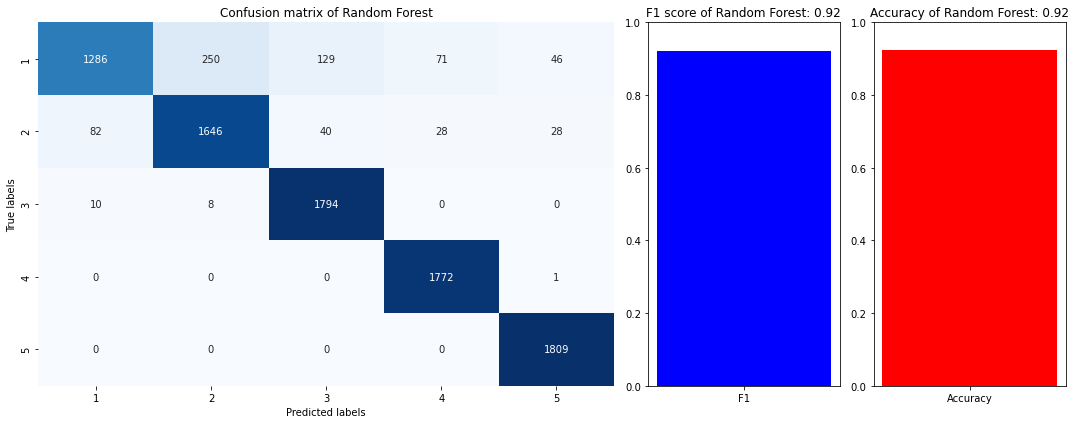

In [ ]:
plot_scores(results_obj['classifier']['RF']['result']['cm'],y_test,results_obj['classifier']['RF']['y_pred'],"Random Forest")

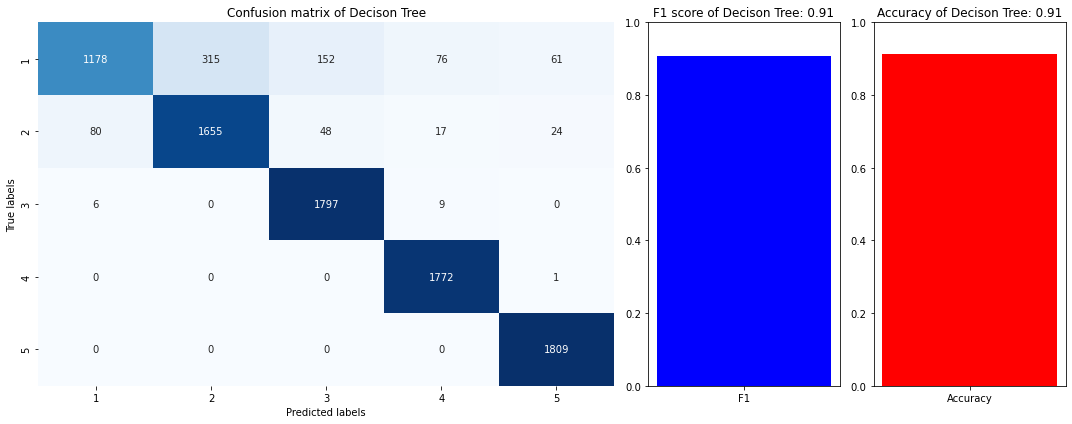

In [ ]:
plot_scores(results_obj['classifier']['DT']['result']['cm'],y_test,results_obj['classifier']['DT']['y_pred'],"Decison Tree")

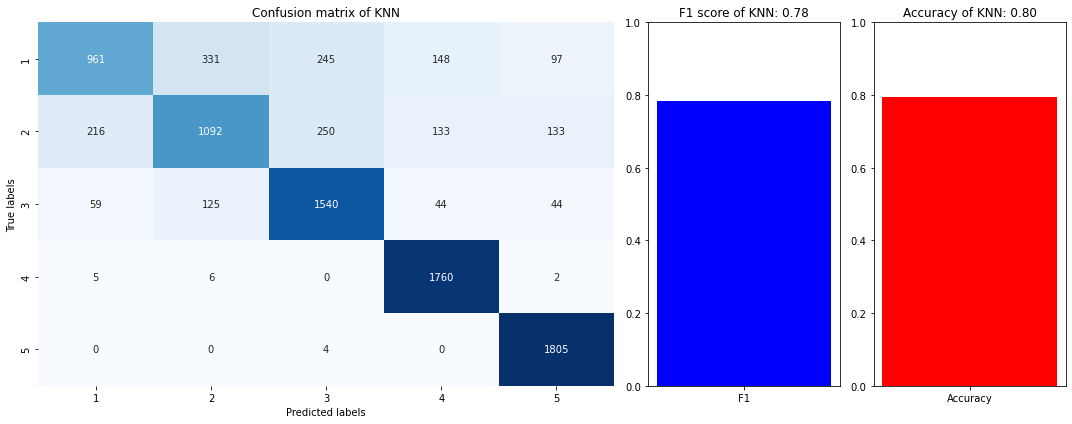

In [ ]:
plot_scores(results_obj['classifier']['KNN']['result']['cm'],y_test,results_obj['classifier']['KNN']['y_pred'],"KNN")

In [ ]:
results_obj['classifier']['RF']['result']['cm']

array([[1286,  250,  129,   71,   46],
       [  82, 1646,   40,   28,   28],
       [  10,    8, 1794,    0,    0],
       [   0,    0,    0, 1772,    1],
       [   0,    0,    0,    0, 1809]], dtype=int64)

In [ ]:
def plotConfusionMatrixAsHeatMap(cm,name):

    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['class 1', 'class 2', 'class 3','class 4','class 5'],
                yticklabels=['class 1', 'class 2', 'class 3','class 4','class 5'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix of ' + name)
    plt.show()

In [ ]:
def plotF1Scores(_ytest,_y_pred,name):
    import matplotlib.pyplot as plt
    from sklearn.metrics import f1_score

    # Compute F1 scores
    f1_scores = f1_score(_ytest, _y_pred, average=None)

    # Plot F1 scores
    plt.bar(range(len(f1_scores)), f1_scores)
    plt.xticks(range(len(f1_scores)), labels=["Class 1", "Class 2", "Class 3","Class 4","Class 5"])
    plt.xlabel("Class")
    plt.ylabel("F1 score")
    plt.title("F1 Score of " + name)
    plt.show()


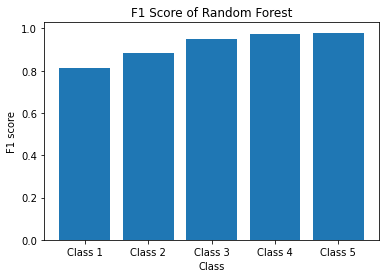

In [ ]:
plotF1Scores(y_test, results_obj['classifier']['RF']['y_pred'],"Random Forest")

In [ ]:
def genrateROCAUCCurve(_y_test,_y_pred,name):
    # Convert multi-class labels to binary format
    y_test_bin = label_binarize(_y_test, classes=[1, 2, 3, 4, 5])
    y_pred_bin = label_binarize(_y_pred, classes=[1, 2, 3, 4, 5])

    # Compute ROC curve and ROC area for each class
    num_classes = 5
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute precision-recall curve and area for each class
    precision = dict()
    recall = dict()
    prc_auc = dict()
    for i in range(0,num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
        prc_auc[i] = auc(recall[i], precision[i])
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    # Plot ROC curves
    for i in range(0,num_classes):
        axs[0].plot(fpr[i], tpr[i], label='ROC curve (class %d) (area = %0.2f)' % (i+1, roc_auc[i]))
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver operating characteristic of ' + name)
    axs[0].legend(loc="lower right")

    # Plot precision-recall curves
    for i in range(0,num_classes):
        axs[1].plot(recall[i], precision[i], label='PR curve (class %d) (area = %0.2f)' % (i+1, prc_auc[i]))
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-recall curve of ' + name)
    axs[1].legend(loc="lower left")

    plt.show()

In [ ]:
generateRUCAUCCurve(results_obj['classifier']['RF']['result']['cm'],y_test,results_obj['classifier']['RF']['y_pred'])

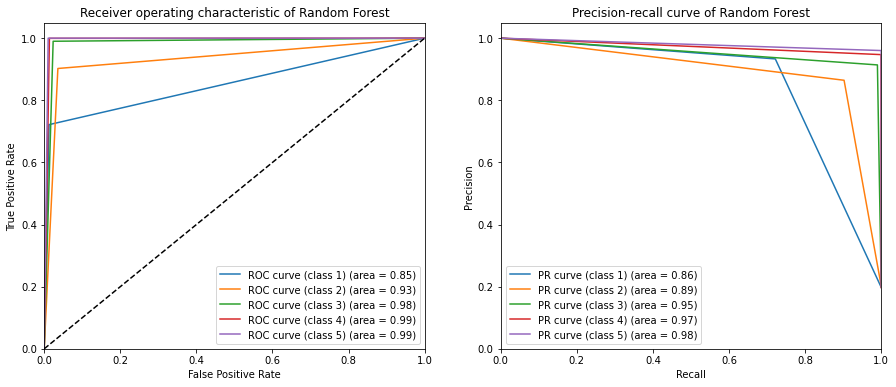

In [ ]:
genrateROCAUCCurve(y_test, results_obj['classifier']['RF']['y_pred'],"Random Forest")

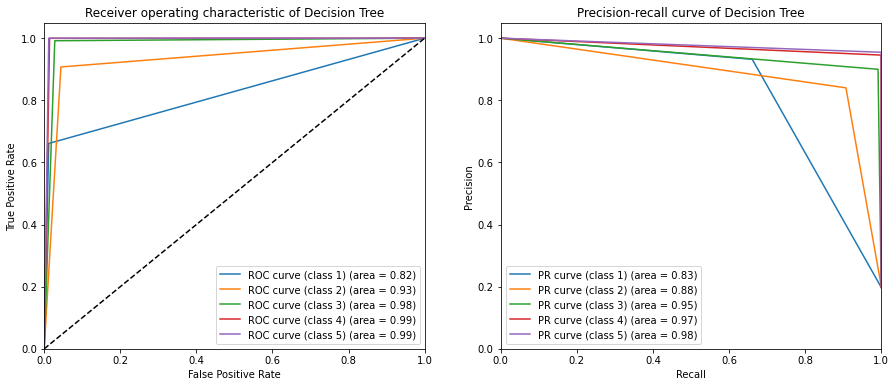

In [ ]:
genrateROCAUCCurve(y_test, results_obj['classifier']['DT']['y_pred'],"Decision Tree")

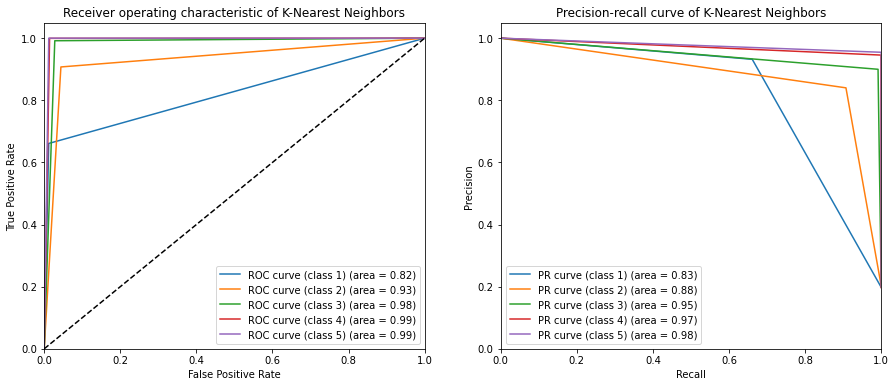

In [ ]:
genrateROCAUCCurve(y_test, results_obj['classifier']['DT']['y_pred'],"K-Nearest Neighbors")

In [ ]:
def plotGraph(grid_search, name):
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    param_grid = grid_search.param_grid
    param_names = list(param_grid.keys())
    combinations = [str(params[i][name]) for i in range(len(params)) for name in param_names]
    plt.plot(combinations, mean_test_scores)
    plt.xlabel('Hyperparameter combinations')
    plt.ylabel('Mean test score')
    plt.title(name + ' Grid Search CV Results')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
def report(grid_search,_x_test,_y_test, name):
    print("GidSearchCV REPORT OF "+ name)
    # Print the best parameters and accuracy score
    print("Best parameters: ", grid_search.best_params_)
    print("Accuracy score: ", grid_search.best_score_)
    print('Mean test score: ', np.mean(grid_search.cv_results_['mean_test_score']) )
    print('Standard deviation test score: ', np.mean(grid_search.cv_results_['std_test_score']))

    # Make predictions on the test data using the best estimator found by GridSearchCV
    _y_pred = grid_search.best_estimator_.predict(_x_test)
    # Compute the error range by subtracting actual from predicted values
    error_range = np.abs(_y_test - _y_pred)

    # Print the error range
    print('Error range: ',  np.mean(error_range))

    # Calculate the accuracy for each class using classification_report
    accuracy_report = classification_report(_y_test, _y_pred)
    # Print the accuracy report
    print('classification report: \n', accuracy_report)

In [ ]:

def grid_search_rf(_x_train,_x_test, _y_train, _y_test):
    param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [5, 10,None],
    'min_samples_split': [2, 5, 10]
    }
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=50)
    grid_search.fit(_x_train, _y_train)
    return grid_search
   

In [ ]:
def grid_search_dt(_x_train,_x_test, _y_train, _y_test):
    param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
    dt = DecisionTreeClassifier()
   # Perform grid search with cross-validation
    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=50)
    grid_search.fit(_x_train, _y_train)
    return grid_search
    
    

In [ ]:
def grid_search_knn(_x_train,_x_test, _y_train, _y_test):
    # Define the parameter grid for the grid search
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    # Create a K-nearest neighbors classifier
    knn = KNeighborsClassifier()
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=50)
    y_pred  = grid_search.fit(_x_train, _y_train)
    return grid_search
    

In [ ]:
def predict(name_rf,name_dt,name_knn):
    print('\n$'+name_rf+'\n')
    rfGS = grid_search_rf(x_train_final,x_test_final, y_train, y_test)
    print('\n'+name_dt+'\n')
    dtGS = grid_search_dt(x_train_final, x_test_final,y_train, y_test)
    print('\n'+name_knn+'\n')
    knnGS = grid_search_knn(x_train_final, x_test_final, y_train, y_test)
    return rfGS,dtGS,knnGS
  

In [ ]:
name_dt = "DECESSION TREE"
name_rf = "RANDOM FOREST"
name_knn = "K-NEAREST NEIGHBOUR"
rfGS,dtGS,knnGS = predict(name_rf,name_dt,name_knn)


$RANDOM FOREST


DECESSION TREE


K-NEAREST NEIGHBOUR



In [ ]:
report(rfGS,x_test_final,y_test, name_rf)

GidSearchCV REPORT OF RANDOM FOREST
Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 20}
Accuracy score:  0.9181904761904762
Mean test score:  0.5683509700176367
Standard deviation test score:  0.017761094825935006
Error range:  0.13744444444444445
classification report: 
               precision    recall  f1-score   support

           1       0.92      0.71      0.81      1782
           2       0.86      0.90      0.88      1824
           3       0.91      0.99      0.95      1812
           4       0.95      1.00      0.97      1773
           5       0.96      1.00      0.98      1809

    accuracy                           0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000



In [ ]:
report(dtGS,x_test_final,y_test, name_dt)

GidSearchCV REPORT OF DECESSION TREE
Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy score:  0.9100952380952382
Mean test score:  0.5891997354497354
Standard deviation test score:  0.01940752984108352
Error range:  0.14577777777777778
classification report: 
               precision    recall  f1-score   support

           1       0.93      0.67      0.78      1782
           2       0.84      0.91      0.87      1824
           3       0.90      0.99      0.94      1812
           4       0.95      1.00      0.97      1773
           5       0.96      1.00      0.98      1809

    accuracy                           0.91      9000
   macro avg       0.92      0.91      0.91      9000
weighted avg       0.92      0.91      0.91      9000



In [ ]:
report(knnGS,x_test_final,y_test, name_knn)

GidSearchCV REPORT OF K-NEAREST NEIGHBOUR
Best parameters:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy score:  0.903952380952381
Mean test score:  0.8368035714285714
Standard deviation test score:  0.014843159943841885
Error range:  0.16722222222222222
classification report: 
               precision    recall  f1-score   support

           1       0.95      0.63      0.76      1782
           2       0.83      0.91      0.87      1824
           3       0.89      0.99      0.94      1812
           4       0.94      1.00      0.97      1773
           5       0.95      1.00      0.97      1809

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.90      9000
weighted avg       0.91      0.91      0.90      9000



In [ ]:
def printCvResults(grid):
    results = pd.DataFrame(grid.cv_results_)
    results = results[['params', 'mean_test_score']]
    # print(results)
    # results = results.sort_values(by='mean_test_score', ascending=False)
    # print(results)
    plt.plot(results.index, results['mean_test_score'])
    plt.xticks(results.index)
    plt.xlabel('Iteration')
    plt.ylabel('Mean Test Accuracy')
    plt.title('Grid Search Results')
    plt.show()

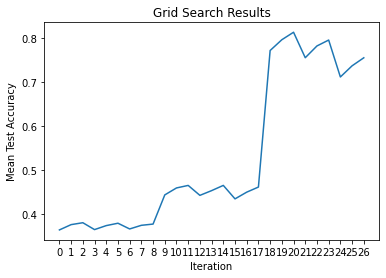

In [ ]:
printCvResults(rfGS)

In [ ]:
mean_test_scores = rfGS.cv_results_['mean_test_score']
params = rfGS.cv_results_['params']
param_grid = rfGS.param_grid
param_names = list(param_grid.keys())
combinations = [str(params[i][name]) for i in range(len(params)) for name in param_names]


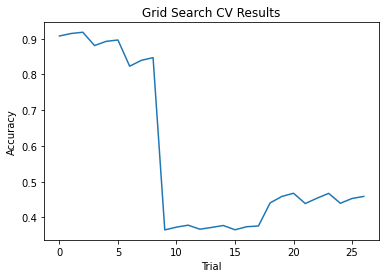

In [ ]:
plt.plot(rfGS.cv_results_['mean_test_score'])
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Grid Search CV Results')
plt.show()

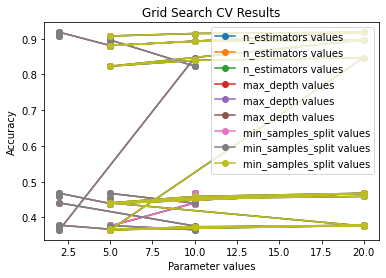

In [ ]:
param_names = list(param_grid.keys())
param_values = [list(x.values()) for x in rfGS.cv_results_['params']]

# Plot the accuracy for each trial with the corresponding parameter values
for i in range(len(param_names)):
    plt.plot(param_values, rfGS.cv_results_['mean_test_score'], '-o', label=param_names[i] + ' values')
plt.legend()
plt.xlabel('Parameter values')
plt.ylabel('Accuracy')
plt.title('Grid Search CV Results')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (81,) and (27,)

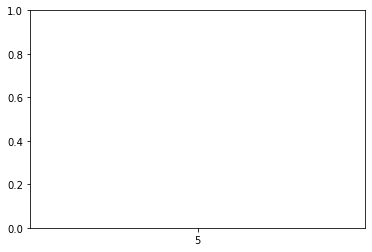

In [ ]:

plt.plot(combinations, mean_test_scores)
plt.xlabel('Hyperparameter combinations')
plt.ylabel('Mean test score')
plt.title(name_rf + ' Grid Search CV Results')
plt.xticks(rotation=90)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (81,) and (27,)

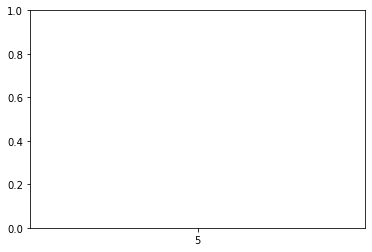

In [ ]:
plotGraph(rfGS,name_rf)
plotGraph(dtGS,name_dt)
plotGraph(knnGS,name_knn)

In [ ]:
# # Make prediction without parameters using K-Fold and Cross-Validation.
# mlModels = []
# mlModels.append(('KNN', KNeighborsClassifier()))
# mlModels.append(('Random Forest', RandomForestClassifier()))
# mlModels.append(('Decision Tree', DecisionTreeClassifier()))

# models = []
# results = []

# for name, model in mlModels:
#   kFold = KFold(n_splits=25, shuffle = True, random_state=123) 
#   cvsResults = cross_val_score(model, x_train, y_train, cv=kFold, scoring='accuracy')
#   results.append(cvsResults)
#   models.append(name)
#   print("%s: %f (%f)" % (name, cvsResults.mean(), cvsResults.std()))

In [ ]:
# # Visualisation for the K-Fold and Cross-Validation
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(models)
# plt.show()

DOWNLAD AS HTML COMMANDS

In [ ]:
# !pip install nbconvert
# jupyter nbconvert --to html u2195157_dissertation.ipynb